## Rešitev

Najprej uvozimo potrebne module in skonfiguriramo matplotlib.

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Sledi uvoz podatkov. Uporabimo `np.loadtxt`, ki ji za vsak slučaj povemo, da delamo s 64-bitnimi inti, ne, kot bi najbrž predpostavila sicer, `float`-i.

In [2]:
np.loadtxt("meritve.txt", dtype=np.int64)

array([[    129,  -61647,  -36969,      -5,      -3],
       [     74,   24912, -111090,       2,      -9],
       [    147,  -98733,   98855,      -8,       8],
       ...,
       [     78,   74129,  -36870,       6,      -3],
       [     58,   12523,  -49280,       1,      -4],
       [    145,   49468,  -61501,       4,      -5]])

Tole je tabela z vsemi podatki. Nam bi bilo prikladneje imeti spremenljivke, ki bi vsebovale stolpce te tabele. Za to tabelo po branju transponiramo - spremenimo vrstice v stolpce in obratno.

In [3]:
np.loadtxt("meritve.txt", dtype=np.int64).T

array([[    129,      74,     147, ...,      78,      58,     145],
       [ -61647,   24912,  -98733, ...,   74129,   12523,   49468],
       [ -36969, -111090,   98855, ...,  -36870,  -49280,  -61501],
       [     -5,       2,      -8, ...,       6,       1,       4],
       [     -3,      -9,       8, ...,      -3,      -4,      -5]])

Če je obrnjena tako, pa jo lahko preprosto razpakiramo v posamične spremenljivke. Celotno branje je torej takšno:

In [4]:
rdata, rx, ry, rvx, rvy = np.loadtxt("meritve.txt", dtype=np.int64).T

### Preprosta rešitev

Od `rx` odštevamo `rvx`, od `ry` pa `rvy` toliko časa, dokler ni največja vrednost manjša od 255.

In [5]:
while np.max(rx) > 255 or np.max(ry) > 255:
    rx -= rvx
    ry -= rvy

In izrišemo.

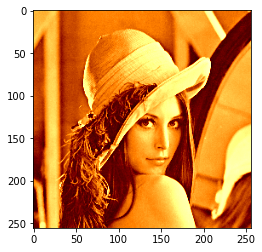

In [6]:
img2 = np.zeros((256, 256))
img2[rx, ry] = rdata
plt.imshow(img2, cmap="afmhot")

## Malo bolj zapletena rešitev

Nikjer ne piše, da so koordinate ravno med 0 in 255. Lahko bi bile tudi med 1000 in 1255. To nam življenja ne zagreni preveč.

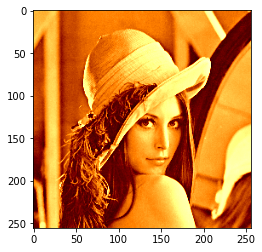

In [7]:
rdata, rx, ry, rvx, rvy = np.loadtxt("meritve.txt", dtype=np.int64).T

while np.max(rx) - np.min(rx) > 255 or np.max(ry) - np.min(ry) > 255:
    rx -= rvx
    ry -= rvy
    
rx -= np.min(rx)
ry -= np.min(ry)

img2 = np.zeros((256, 256))
img2[rx, ry] = rdata
plt.imshow(img2, cmap="afmhot")

Zanka zdaj teče, dokler je razpon po x ali y večji od 255. Po njej odštejemo minimume. Če so koordinate med, recimo 1500 in 1755, bomo tako odšteli 1500, pa bodo med 0 in 255.

Pri teh podatkih te komplikacije niso potrebne, v splošnem pa bi lahko bile.

Ne spreglejte, kako hiter je program. Na mojem računalniku potrebuje dobri dve sekundi. Zanka se obrne 12345-krat (spoiler: toliko stoletij nazaj je potrebno iti) in v vsaki mora izračunati štiri minimume in maksimume ter dve razliki prek 65536 elementov. Torej

In [8]:
12345 * 6 * 65536

4854251520

operacij. Skoraj pet milijard. Numpy to zmore, v čistem Pythonu pa bi to vzelo ... ne ravno celo stoletje, vendar kar nekaj časa.

### Še splošnejša rešitev

V lanski različici naloge ni bilo podatka o tem, da je slika velika 256x256. Lahko bi bila tudi, recimo, 128x512. Prav tako bi lahko na mestih, kjer je slika najtemnejša, zvezda preprosto manjkala, tako da jih niti ne bi bilo 65536.

V tem primeru bi nalogo reševali tako, da bi predpostavili, da je slika pravilna takrat, ko je bila najmanjša. Tudi to ni nujno res, je pa kar varno.

Pri takšnih nalogah je najbrž smiselno najprej predpostaviti, da avtorji niso bili preveč hudobni. Šele če takšni, preprosti pristopi ne delujejo, poskusimo kaj bolj sofisticiranega, recimo ocenjevanje, kako lep pravokotnik tvorijo točke v posameznem trenutku simulacije vrtenja časa nazaj.

Zdaj bomo premikali `rx` (koordinate x) v smeri `-rvx` (hitrost v smeri x, obrnjena nazaj) toliko časa, dokler to zmanjšuje razliko med največjo in najmanjšo vrednostjo. Pri tem štejemo korake.

`tm` bo trenutna razlika, `pm` pa prejšnja. V začetku se delamo, da je bila prejšnja malo večja od trenutne.

Ker je zanka napisana tako, da teče, dokler se razdalja ne poveča, naredi en korak preveč. Po zanki zato zmanjšamo `i` in popravimo `rx`.

In [9]:
rdata, rx, ry, rvx, rvy = np.loadtxt("meritve.txt", dtype=np.int64).T

tm = np.max(rx) - np.min(rx)
pm = tm + 1
i = 0
while pm > tm:
    rx -= rvx
    tm, pm = np.max(rx) - np.min(rx), tm
    i += 1
    
i -= 1
rx += rvx

Število korakov je

In [10]:
i

12345

kar izgleda dovolj nenaključno. :)

Zdaj prestavimo še `ry` za `-rvx` korakov - kar brez zanke, z množenjem.

In [11]:
ry -= i * rvy

In izrišemo sliko, da vidimo, ali smo naredili pravilno.

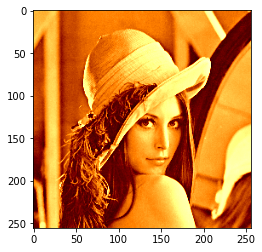

In [12]:
img2 = np.zeros((256, 256))
img2[rx, ry] = rdata
plt.imshow(img2, cmap="afmhot")

## Sestavljanje

Mogoče bo čisto zanimivo videti, kako sem nalogo sestavil.

Na kratko, tako:

In [13]:
N = 12345

img = mpimg.imread('lena.png')
data = (255 * img[:, :, 0]).astype(np.uint8).flatten()

x, y = np.mgrid[:256, :256]
x, y = np.vstack((x.flatten(), y.flatten()))

vx = np.random.randint(-10, 10, 65536)
vy = np.random.randint(-10, 10, 65536)

xx = x + vx * N
yy = y + vy * N

perm = np.arange(65536)
np.random.shuffle(perm)
rx, ry, rvx, rvy, rdata = xx[perm], yy[perm], vx[perm], vy[perm], data[perm]

np.savetxt("meritve_2.txt", np.vstack((rdata, rx, ry, rvx, rvy)).T, fmt="%i")

Zdaj pa razlaga po korakih.

Odločil sem se za

In [14]:
N = 12345

korakov, ker je bilo videti dovolj veliko, da bo naloga težko rešljiva v čistem Pythonu, brez numpyja. Simulacija bi namreč zahtevala

In [15]:
N * 65536

809041920

se pravi skoraj milijardo odštevanj, kar čisti Python sicer zmore, ni pa prav hiter. Sploh pa to ne gre, če moramo pri pisanju še kaj malega eksperimentirati.

Preberemo sliko (datoteka že vsebuje sivinsko sliko, da se ni treba zafrkavati z združevanjem komponent).

In [16]:
img = mpimg.imread('lena.png')
img

array([[[0.6313726 , 0.6313726 , 0.6313726 , 1.        ],
        [0.6313726 , 0.6313726 , 0.6313726 , 1.        ],
        [0.6156863 , 0.6156863 , 0.6156863 , 1.        ],
        ...,
        [0.6627451 , 0.6627451 , 0.6627451 , 1.        ],
        [0.6627451 , 0.6627451 , 0.6627451 , 1.        ],
        [0.49411765, 0.49411765, 0.49411765, 1.        ]],

       [[0.6313726 , 0.6313726 , 0.6313726 , 1.        ],
        [0.6313726 , 0.6313726 , 0.6313726 , 1.        ],
        [0.6156863 , 0.6156863 , 0.6156863 , 1.        ],
        ...,
        [0.67058825, 0.67058825, 0.67058825, 1.        ],
        [0.6627451 , 0.6627451 , 0.6627451 , 1.        ],
        [0.49411765, 0.49411765, 0.49411765, 1.        ]],

       [[0.6392157 , 0.6392157 , 0.6392157 , 1.        ],
        [0.60784316, 0.60784316, 0.60784316, 1.        ],
        [0.62352943, 0.62352943, 0.62352943, 1.        ],
        ...,
        [0.58431375, 0.58431375, 0.58431375, 1.        ],
        [0.4862745 , 0.486274

Kot nam pove

In [17]:
img.shape

(256, 256, 4)

je tole matrika dimenzij 256x256x4 -- širina krat višina krat število barvnih komponent, torej R, G, B in neprosojnost. Zanima nas samo prva komponenta, torej se otresimo ostalih.

In [18]:
img = img[:, :, 0]
img

array([[0.6313726 , 0.6313726 , 0.6156863 , ..., 0.6627451 , 0.6627451 ,
        0.49411765],
       [0.6313726 , 0.6313726 , 0.6156863 , ..., 0.67058825, 0.6627451 ,
        0.49411765],
       [0.6392157 , 0.60784316, 0.62352943, ..., 0.58431375, 0.4862745 ,
        0.24313726],
       ...,
       [0.21176471, 0.18039216, 0.20392157, ..., 0.34509805, 0.36078432,
        0.3529412 ],
       [0.16470589, 0.18039216, 0.18039216, ..., 0.3764706 , 0.40784314,
        0.38431373],
       [0.17254902, 0.19607843, 0.18039216, ..., 0.40784314, 0.40784314,
        0.42352942]], dtype=float32)

In [19]:
img.shape

(256, 256)

Pomnožimo svetlosti, ki so med 0 in 1, z 255 ter spremenimo v nepredznačen int8

In [20]:
img = (255 * img).astype(np.uint8)
img

array([[161, 161, 157, ..., 169, 169, 126],
       [161, 161, 157, ..., 171, 169, 126],
       [163, 155, 159, ..., 149, 124,  62],
       ...,
       [ 54,  46,  52, ...,  88,  92,  90],
       [ 42,  46,  46, ...,  96, 104,  98],
       [ 44,  50,  46, ..., 104, 104, 108]], dtype=uint8)

Zdaj pa matriko zbašimo v enodimenzionalno matriko, tako da zložimo vrstico za vrstico.

In [21]:
data = img.flatten()
data

array([161, 161, 157, ..., 104, 104, 108], dtype=uint8)

In [22]:
data.shape

(65536,)

Zdaj pa moramo pripraviti koordinate in hitrosti. Takole sestavimo seznam vseh možnih parov števil med 0 in 255.

In [23]:
x, y = np.mgrid[:256, :256]
coords = np.vstack((x.flatten(), y.flatten()))
x, y = coords

In [24]:
coords

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   1,   2, ..., 253, 254, 255]])

Izmislimo si naključne hitrosti in izračunamo koordinate čez `N` časa.

In [25]:
vx = np.random.randint(-10, 10, 65536)
vy = np.random.randint(-10, 10, 65536)

xx = x + vx * N
yy = y + vy * N

Pripravimo naključno premešana števila med 0 in 65535. Podatke, ki jih moramo shraniti, torej `xx`, `yy` `rvx`, `rvy` in `data` indeksiramo s tako premešanimi števili, pa dobimo premešane podatke.

In [26]:
perm = np.arange(65536)
np.random.shuffle(perm)

rx, ry, rvx, rvy, rdata = xx[perm], yy[perm], vx[perm], vy[perm], data[perm]

Preskusimo, če smo naredili pravilno: če ustvarimo novo sliko `img2` in na indekse `[rx - rvx * N, ry - rvy * N]` zapišemo podatke iz `rdata`, moramo dobiti originalno sliko.

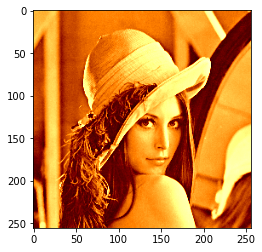

In [27]:
img2 = np.zeros((256, 256))
img2[rx - rvx * N, ry - rvy * N] = rdata
plt.imshow(img2, cmap="afmhot")

Deluje. Zdaj shranimo podatke v datoteko.

In [28]:
np.savetxt("meritve_2.txt", np.vstack((rdata, rx, ry, rvx, rvy)).T, fmt="%i")

## Kdo je na sliki

Slika se imenuje Lena, na njej je [Lena Forsen](https://en.wikipedia.org/wiki/Lena_Fors%C3%A9n), "first lady of the internet". Gre za silno znano sliko, ki so jo uporabljali pri, recimo, razvoju formata JPG. Štorija pravi, da sta se nek doktorski študent in njegov mentor naveličala, da so na konferencah stalno ene in iste slike in ravno takrat je prišel mimo nekdo s Playboyem. Na fotografiji je le zgornja tretjina slike iz revije. Iz razlogov.

Gre za [standardno testno sliko](https://en.wikipedia.org/wiki/Lenna) in vse to je bila dolgo "dobra fora". V današnjih časih smo na takšne stvari malo bolj občutljivi in sem ter tja kdo pomisli tudi, recimo, kako se ob muzajočih se študentih, ki v predavalnici jadrno brskajo za originalno, celotno sliko, počutijo redke študentke.

Toliko, da bo imela naloga še moralni poduk, čeprav ... sem tudi sam kriv, saj je bila to prva slika, ki mi je prišla na misel za to nalogo.

Če koga zanima več, si lahko pogleda [zanimiv polurni video o tem](https://www.facebook.com/codelikeagirlau/videos/985614161797010/).